In [2]:
!pip install pytorch-tabnet wget

Defaulting to user installation because normal site-packages is not writeable


In [3]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

/Users/melicias/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download ForestCoverType dataset

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [8]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    


File already exists.


# Load data and split
Same split as in original paper

In [15]:
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    int_columns + bool_columns + [target])

print(feature_columns)


['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Covertype']


In [10]:
train = pd.read_csv(out, header=None, names=feature_columns)

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [14]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)
print(train)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

        Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0            2596      51      3                               258   
1            2590      56      2                               212   
2            2804     139      9                               268   
3            2785     155     18                               242   
4            2595      45      2                               153   
...           ...     ...    ...                               ...   
581007       2396     153     20                                85   
581008       2391     152     19                                67   
581009       2386     159     17                                60   
581010       2384     170     15                                60   
581011       2383     165     13                                60   

        Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                                    0                              510   
1        

# Define categorical features for categorical embeddings

In [16]:
unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 
print(features)

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


# Network parameters

In [15]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/Users/melicias/.local/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Training

In [17]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [27]:
print(y_valid)
max_epochs = 5 if not os.getenv("CI", False) else 2

[2 3 2 ... 3 3 3]


In [18]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256
) 

epoch 0  | loss: 1.23982 | train_accuracy: 0.03694 | valid_accuracy: 0.0367  |  0:02:23s
epoch 1  | loss: 0.7875  | train_accuracy: 0.18219 | valid_accuracy: 0.182   |  0:04:40s
epoch 2  | loss: 0.70836 | train_accuracy: 0.1404  | valid_accuracy: 0.14038 |  0:06:56s
epoch 3  | loss: 0.67642 | train_accuracy: 0.14056 | valid_accuracy: 0.1399  |  0:09:17s
epoch 4  | loss: 0.6637  | train_accuracy: 0.09832 | valid_accuracy: 0.09834 |  0:11:48s
Stop training because you reached max_epochs = 5 with best_epoch = 1 and best_valid_accuracy = 0.182


/Users/melicias/.local/lib/python3.7/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


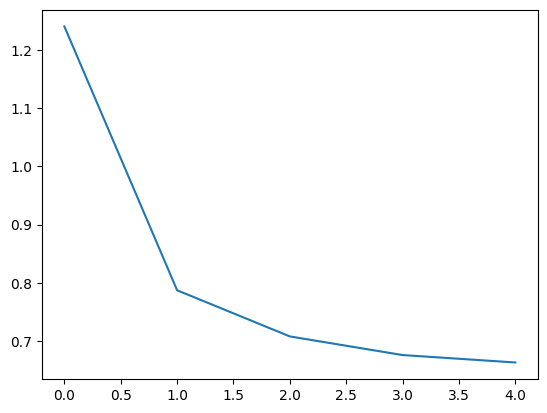

In [19]:
# plot losses
plt.plot(clf.history['loss'])

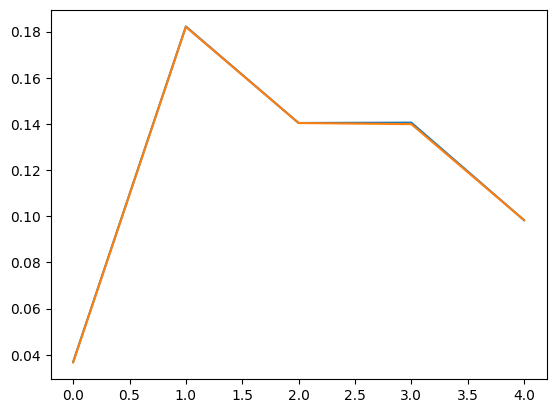

In [20]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

### Predictions


In [21]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : 0.1820030076740869
FINAL TEST SCORE FOR forest-cover-type : 0.18368716814540073


In [22]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.18368716814540073


# Save and load Model

In [23]:
# save state dict
saved_filename = clf.save_model('test_model')

Successfully saved model at test_model.zip


In [24]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

/Users/melicias/.local/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [25]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.18368716814540073


In [26]:
assert(test_acc == loaded_test_acc)

# Global explainability : feat importance summing to 1

In [27]:
clf.feature_importances_

array([3.63625075e-01, 1.01120202e-07, 6.70874849e-03, 1.69044072e-04,
       1.78334766e-02, 3.67306905e-02, 2.97367301e-02, 0.00000000e+00,
       1.41101842e-02, 1.27282367e-02, 1.46376737e-02, 3.06284974e-03,
       2.38007968e-02, 2.85408496e-03, 2.82641175e-05, 2.17023943e-06,
       7.77504035e-04, 6.60935719e-05, 2.00429862e-04, 3.60931373e-04,
       7.23199089e-03, 2.44026301e-05, 4.52118235e-02, 2.11035260e-04,
       3.36230342e-08, 3.66339204e-03, 7.47976092e-08, 1.58152554e-05,
       1.62283750e-05, 6.53535049e-06, 0.00000000e+00, 4.89508663e-08,
       1.10139408e-04, 7.99861449e-02, 3.31948667e-04, 6.62303149e-04,
       0.00000000e+00, 7.41023182e-03, 4.59698617e-04, 2.10904845e-04,
       1.61282395e-01, 3.73314440e-05, 4.37178928e-04, 0.00000000e+00,
       2.11128482e-04, 5.02465653e-07, 1.25318208e-04, 7.26620770e-03,
       3.51862089e-05, 3.19017272e-04, 2.08868936e-08, 1.32881374e-01,
       2.08551772e-02, 3.56332576e-03])

# Local explainability and masks

In [28]:
explain_matrix, masks = clf.explain(X_test)

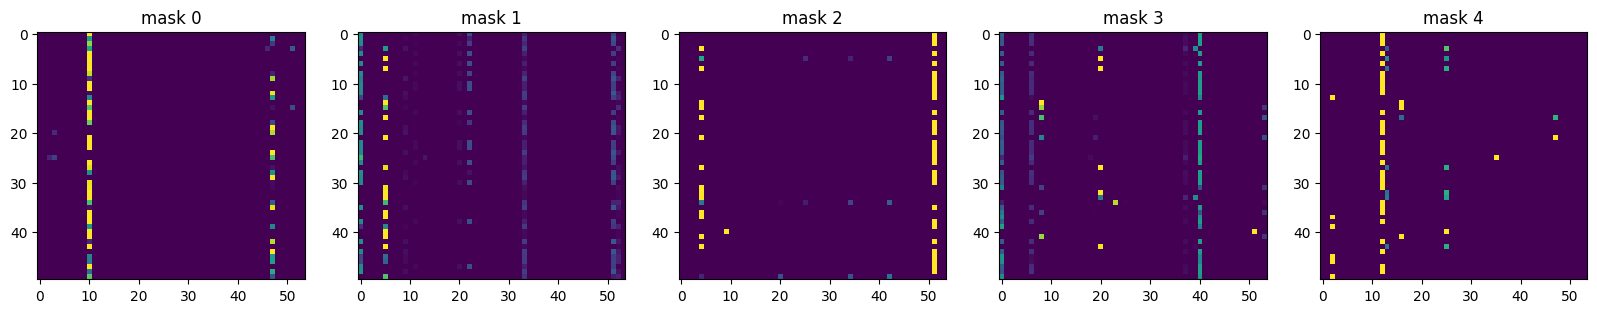

In [29]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [49]:
n_estimators = 1000 if not os.getenv("CI", False) else 20

In [50]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="multi:softproba",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)
le = LabelEncoder()
y_valid = le.fit_transform(y_valid)
clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=40,
            verbose=10)

/Users/melicias/.local/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  if eval_set is not None:


[0]	validation_0-mlogloss:1.74261
[10]	validation_0-mlogloss:0.90294
[20]	validation_0-mlogloss:0.63492
[30]	validation_0-mlogloss:0.52129
[40]	validation_0-mlogloss:0.46317
[50]	validation_0-mlogloss:0.42549
[60]	validation_0-mlogloss:0.40176
[70]	validation_0-mlogloss:0.38531
[80]	validation_0-mlogloss:0.37286
[90]	validation_0-mlogloss:0.36102
[100]	validation_0-mlogloss:0.34975
[110]	validation_0-mlogloss:0.33910
[120]	validation_0-mlogloss:0.32853
[130]	validation_0-mlogloss:0.32014
[140]	validation_0-mlogloss:0.31275
[150]	validation_0-mlogloss:0.30271
[160]	validation_0-mlogloss:0.29446
[170]	validation_0-mlogloss:0.28664
[180]	validation_0-mlogloss:0.27811
[190]	validation_0-mlogloss:0.26911
[200]	validation_0-mlogloss:0.26338
[210]	validation_0-mlogloss:0.25701
[220]	validation_0-mlogloss:0.25125
[230]	validation_0-mlogloss:0.24481
[240]	validation_0-mlogloss:0.23912
[250]	validation_0-mlogloss:0.23402
[260]	validation_0-mlogloss:0.22921
[270]	validation_0-mlogloss:0.22371
[28

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0, ...)

In [4]:
preds_valid = np.array(clf_xgb.predict_proba(X_valid))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1) + 1, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1) + 1, y_true=y_test)
print(test_acc)

NameError: name 'clf_xgb' is not defined